In [77]:
import torch
import torchvision.transforms.v2 as transforms
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
import numpy as np
import glob
import os
import warnings
from matplotlib import pyplot as plt
import cv2
import pandas as pd

%matplotlib inline
%config InlineBackend.figure_formats = 'retina'
warnings.filterwarnings("ignore")

In [2]:
train_path = "Classification_data/train/"
test_path = "Classification_data/test/"

In [5]:
class2ind = {}
ind2class = {}

In [6]:
for i, folder in enumerate(os.listdir(train_path)):
   ind2class[i]=folder

In [7]:
class2ind={ind2class[i]: i  for i in range(len(ind2class))}

In [8]:
class2ind

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [24]:
def get_data(path):
    data = []
    labels = []
    for folder in glob.glob(path + '/*'):
        for filename in glob.glob(folder + "/*.jpg"):
        # print(filename)
            image = cv2.imread(filename)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            data.append(torch.tensor(image))
            label = filename.split('\\')[-2]
            labels.append(class2ind[label])

    return data, labels


In [25]:
train_data, train_labels = get_data(train_path)
test_data, test_labels = get_data(test_path)

### Create custom dataset of images

In [91]:
class ImageDataset(Dataset):
    def __init__(self, data, labels, transform=None, target_transform=None):
        self.img_data = data
        self.img_labels = labels
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        image = self.img_data[idx]
        label = self.img_labels[idx]
        if self.transform:
            image =self.transform(image)
            print("transformed")
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [92]:
train_dataset = ImageDataset(train_data, train_labels)

In [93]:
train_dataset

In [99]:
image, label = train_dataset[14000]

In [100]:
print(image)

tensor([[[246, 255, 251],
         [219, 225, 221],
         [175, 174, 170],
         ...,
         [117, 150, 167],
         [141, 177, 201],
         [102, 142, 167]],

        [[238, 249, 243],
         [241, 247, 243],
         [190, 189, 187],
         ...,
         [ 86, 117, 135],
         [123, 159, 181],
         [154, 192, 215]],

        [[231, 240, 237],
         [235, 240, 236],
         [126, 125, 123],
         ...,
         [154, 181, 200],
         [180, 212, 233],
         [174, 209, 231]],

        ...,

        [[103,  98, 104],
         [104,  99, 105],
         [104, 102, 107],
         ...,
         [ 64,  64,  72],
         [ 43,  44,  49],
         [ 49,  50,  55]],

        [[106, 101, 107],
         [106, 101, 107],
         [106, 104, 109],
         ...,
         [ 59,  60,  65],
         [ 60,  61,  66],
         [ 33,  34,  39]],

        [[112, 107, 113],
         [110, 105, 111],
         [106, 104, 109],
         ...,
         [ 60,  61,  66],
        

In [101]:
image.dtype

torch.uint8

In [88]:
def visualise_images(dataset):
    fig, axs = plt.subplots(2, 5, figsize=(20, 10))
    idx = np.random.randint(0, len(dataset), 10)
    for i, index in enumerate(idx):
        axs[i//5, i%5].imshow(dataset[index][0])
        axs[i//5, i%5].axis("off")
        title = ind2class[dataset[index][1]]
        axs[i//5, i%5].set_title(f"Class {title}")

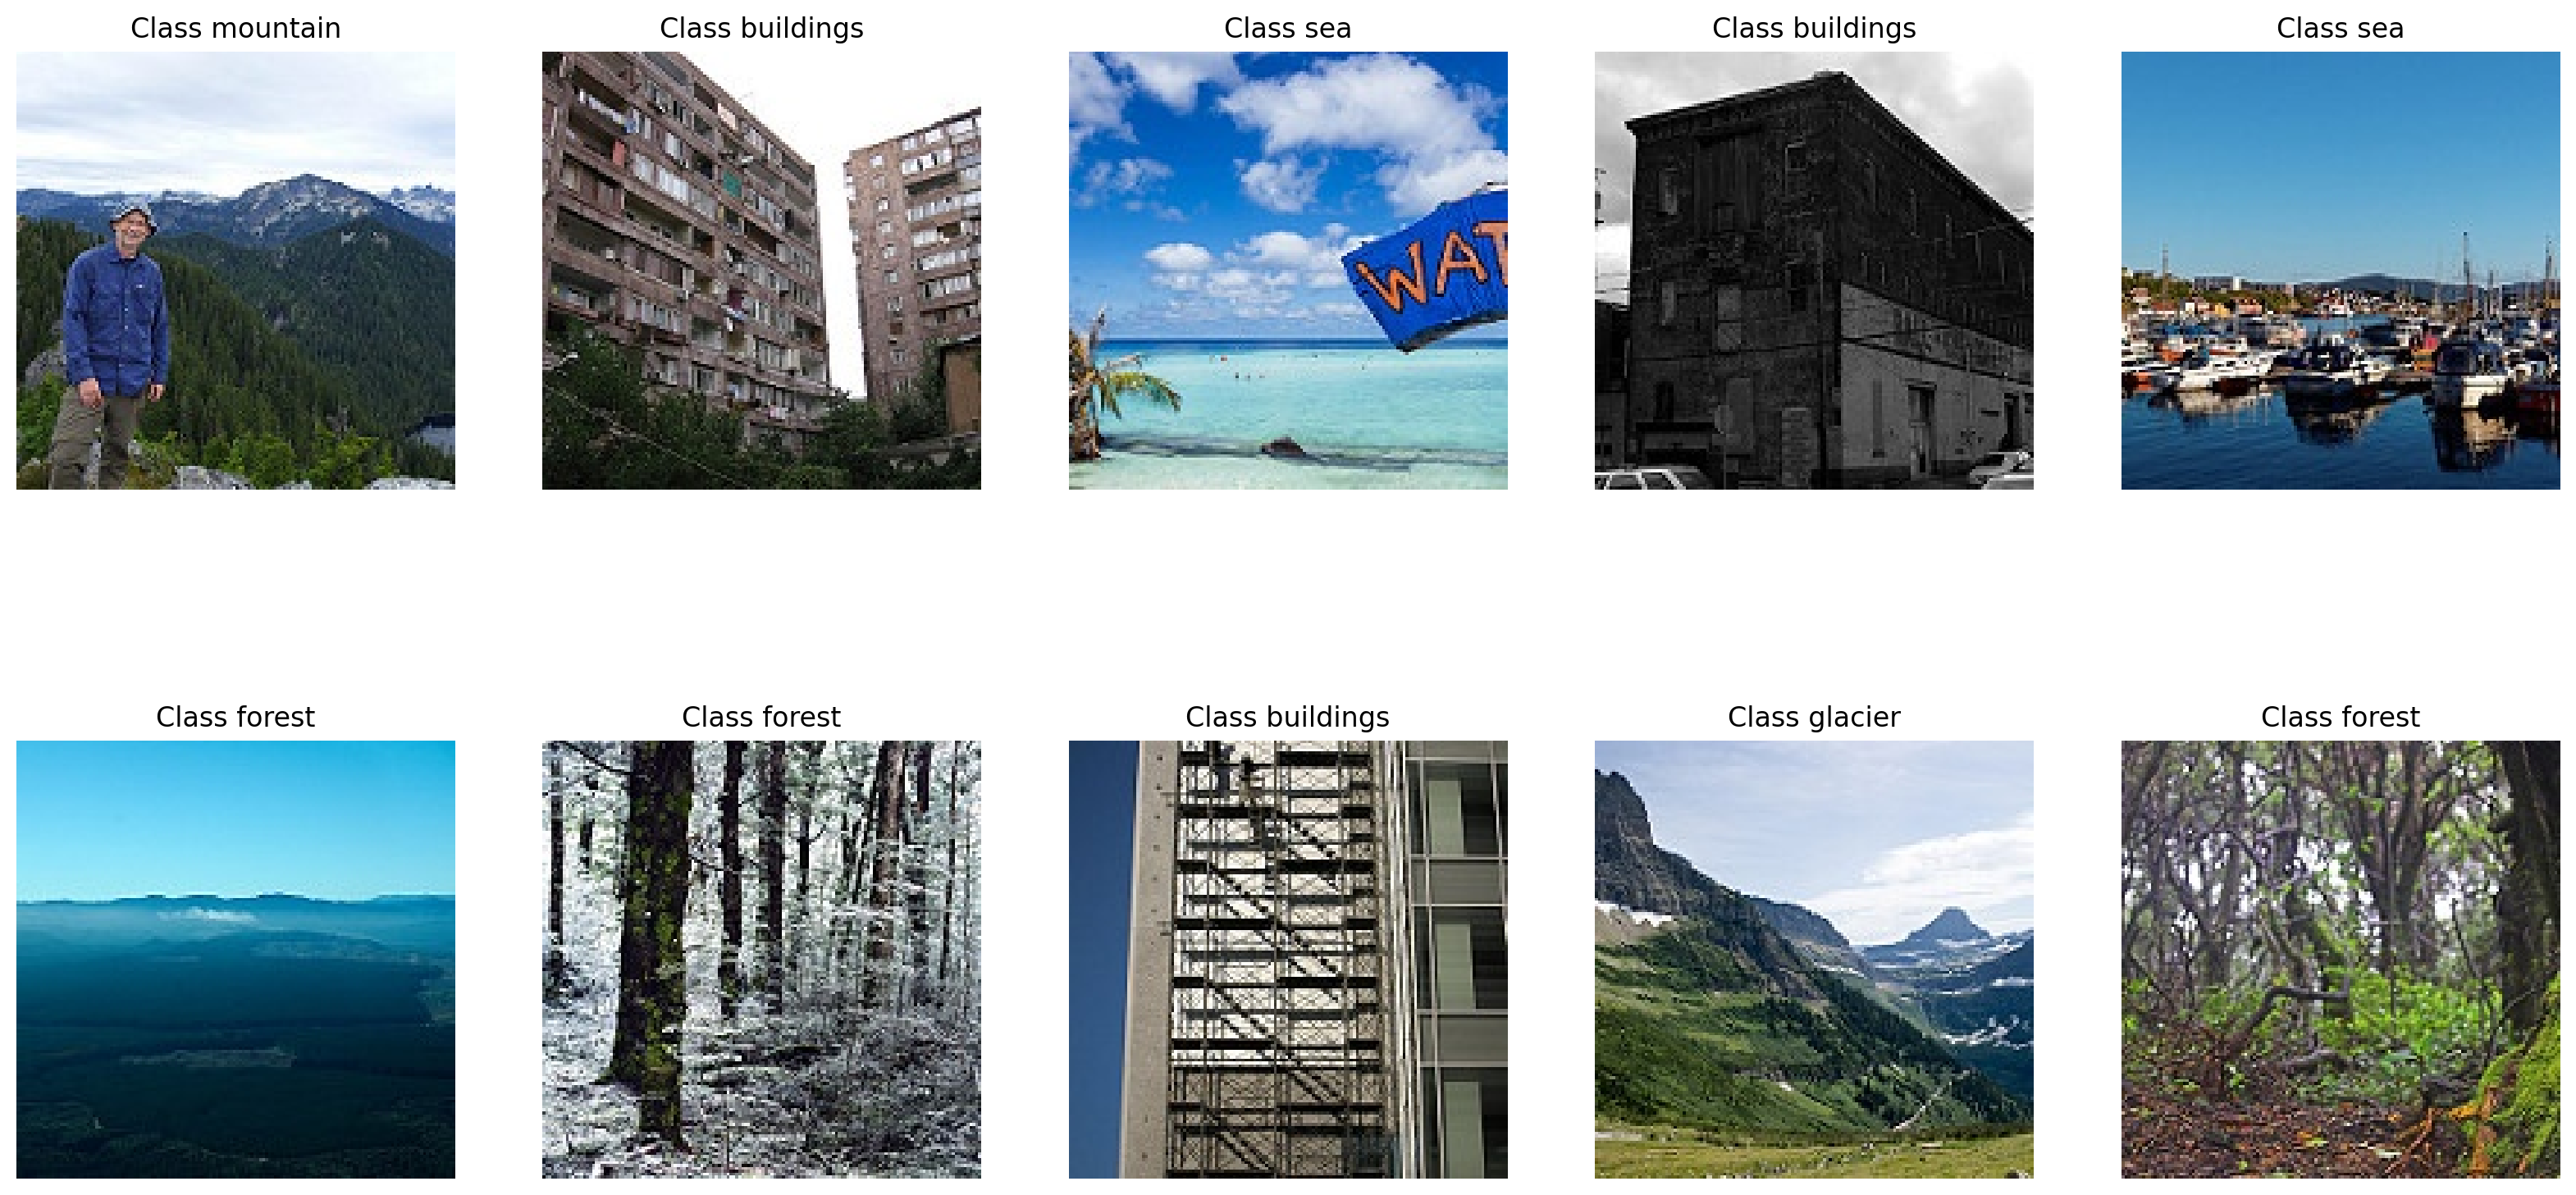

In [98]:
visualise_images(train_dataset)

In [105]:
transform = transforms.Compose(
    [
        transforms.ToImageTensor(),
        transforms.ConvertImageDtype(torch.float32),
        transforms.CenterCrop((150, 150)),
        transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
    ]
)

In [106]:
transform(train_dataset[14000][0])

RuntimeError: The size of tensor a (150) must match the size of tensor b (3) at non-singleton dimension 0

In [86]:
transform(train_dataset[0][0])

TypeError: 'Compose' object is not iterable

In [84]:
train_dataset = ImageDataset(train_data, train_labels, transform=transform)

TypeError: 'Compose' object is not iterable

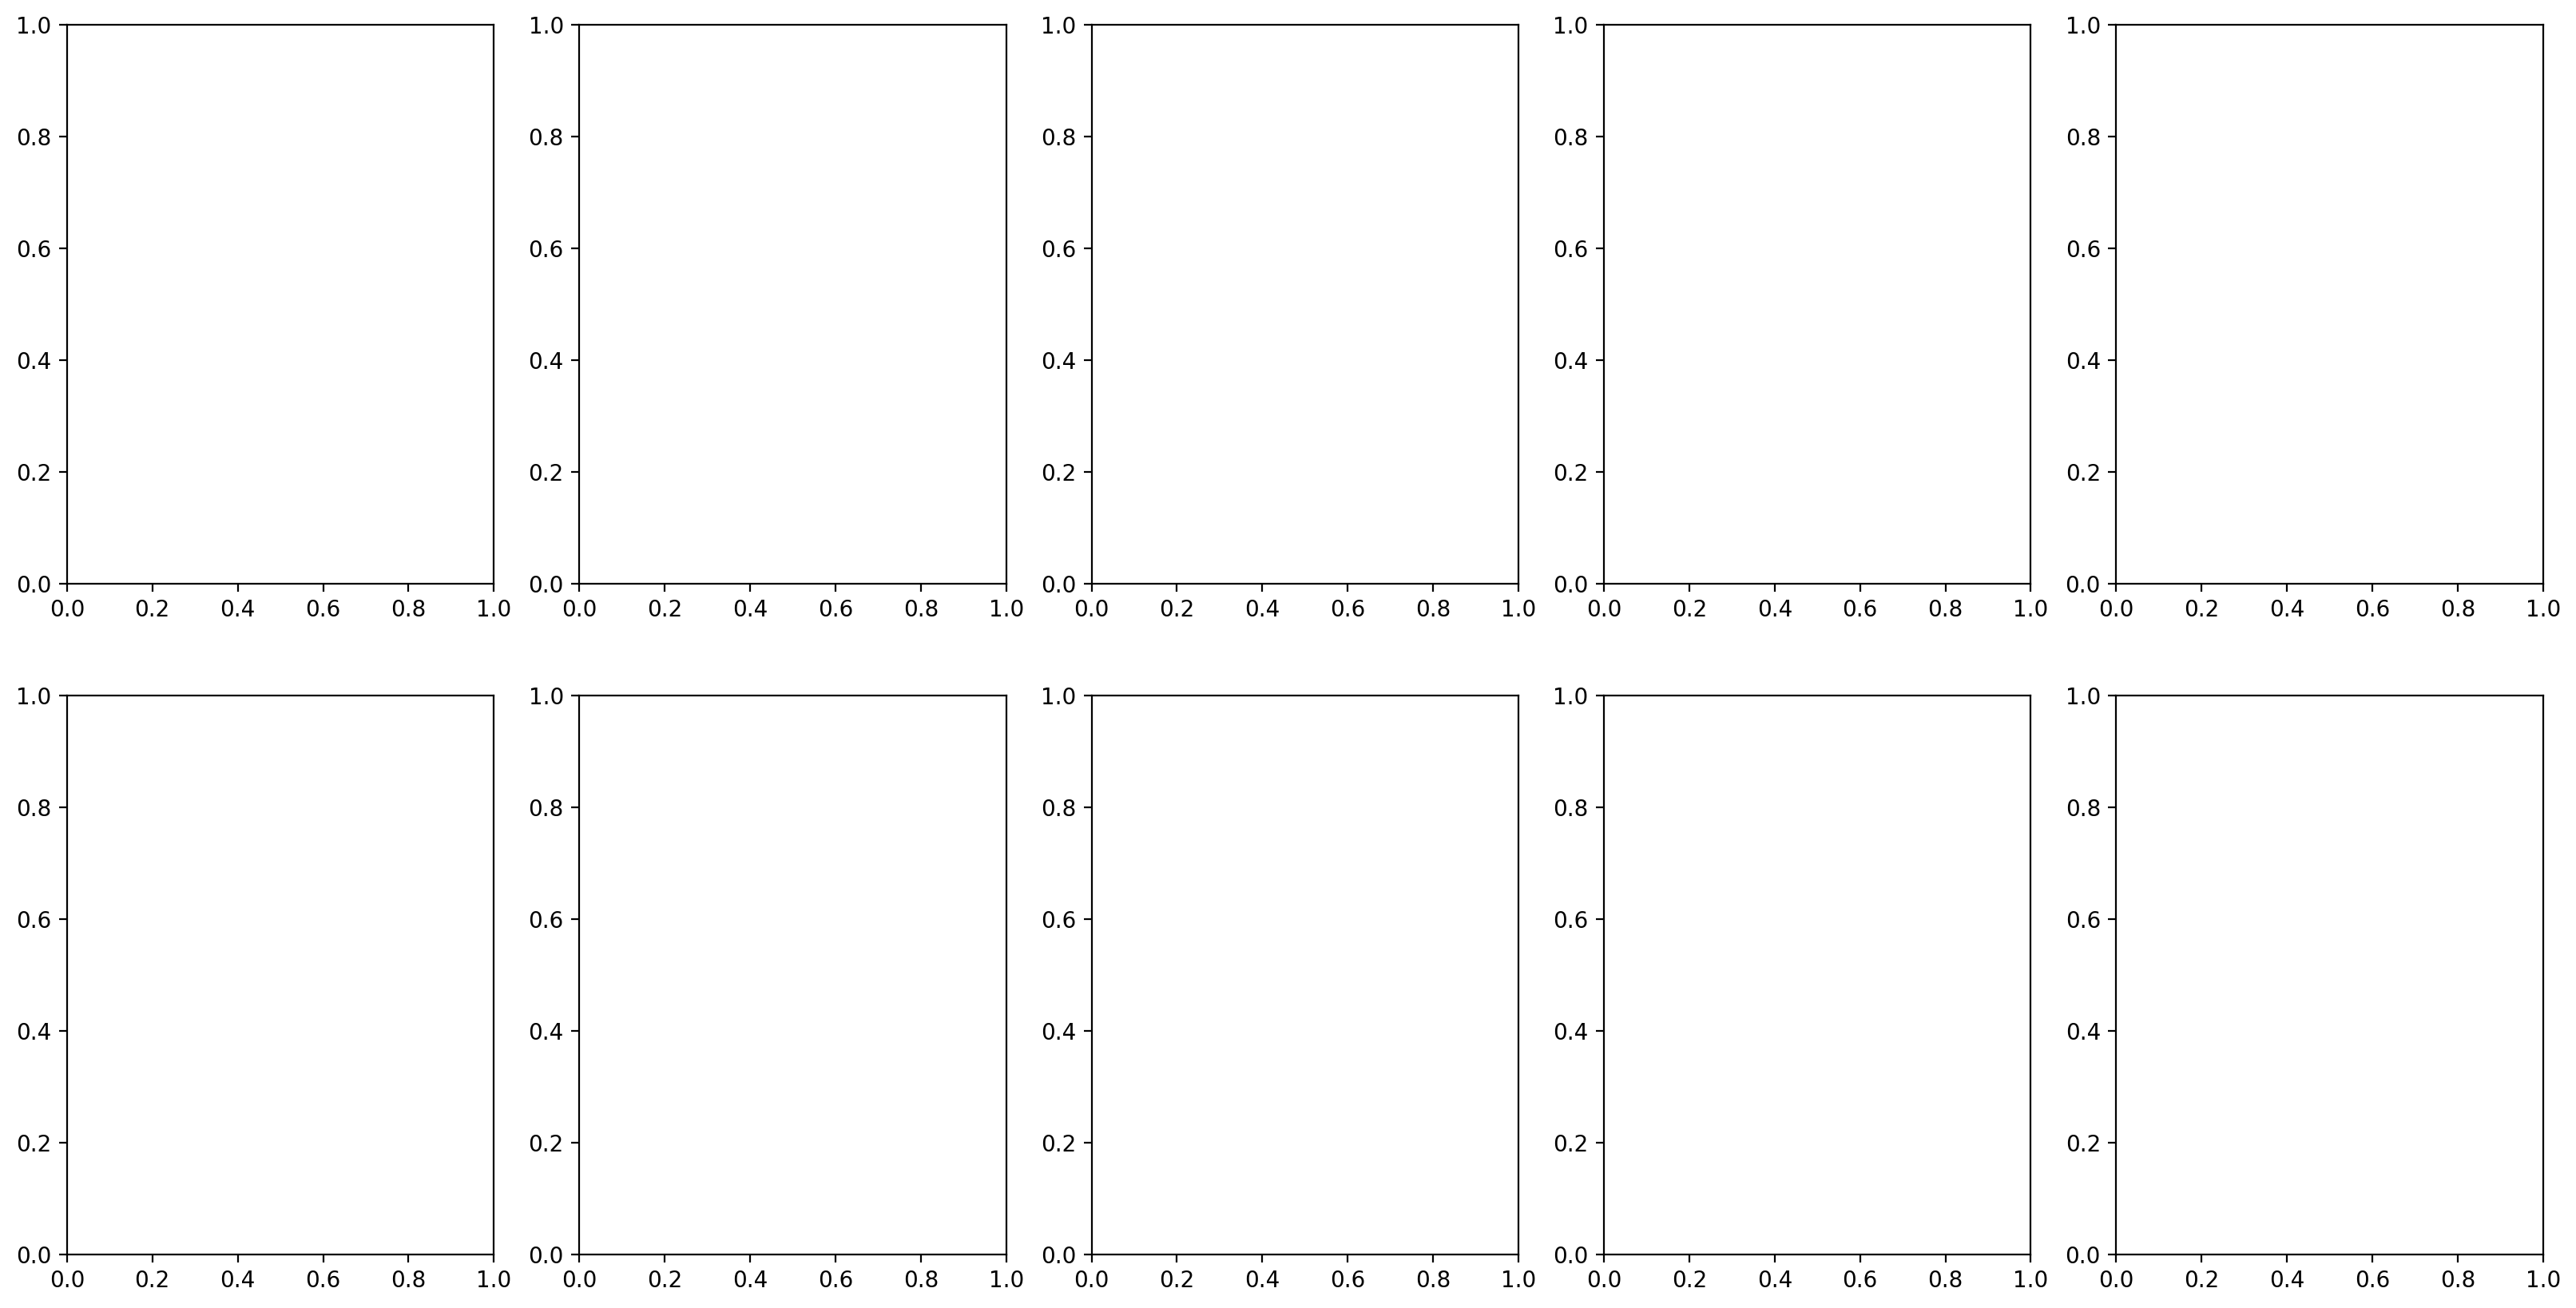

In [85]:
visualise_images(train_dataset)